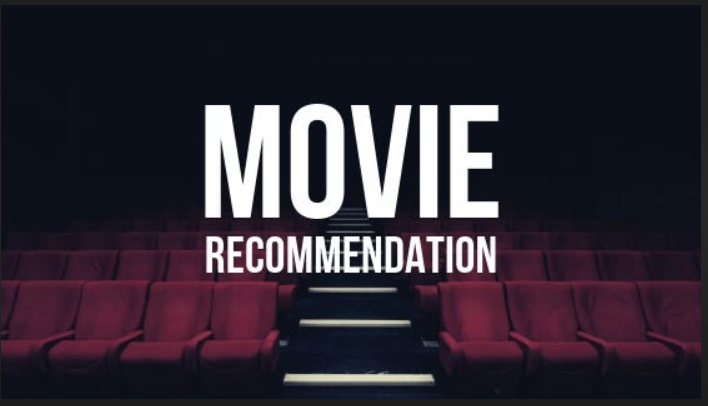

#Context

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

#Know Your Data

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
movies = pd.read_fwf('zee-movies.dat',encoding='ISO-8859-1')
users = pd.read_fwf('zee-users.dat',encoding='ISO-8859-1')
ratings = pd.read_fwf('zee-ratings.dat',encoding='ISO-8859-1')

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


In [ ]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB


In [ ]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 1 columns):
 #   Column                              Non-Null Count    Dtype 
---  ------                              --------------    ----- 
 0   UserID::MovieID::Rating::Timestamp  1000209 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [ ]:
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


- There are 3 different data sets each for Users, Movies and Ratings
- Users data include information like UserID, Gender, Age, Occupation and Zip Code
- Movies data include information like MovieID, Title and Genre
- Ratings data include information like UserID, MovieID, Rating and Timestamp
- Datasets require data cleaning and structuring which will follow in next section

#Data Cleaning / Feature Engg

##Movies Dataframe

In [ ]:
movies.drop(columns=['Unnamed: 1', 'Unnamed: 2'], axis=1, inplace=True)
delimiter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter, expand=True)

In [ ]:
movies.columns = ['MovieID', 'Title', 'Genres']

In [ ]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


- Segregate Movie Name and Year of Release from Title column
- Segregate Genres for further granularity

In [ ]:
# Extract Movie Name and Release Year from Title
movies['MovieName'] = movies['Title'].str.extract(r'^(.*)\s\((\d{4})\)$')[0]
movies['ReleaseYear'] = movies['Title'].str.extract(r'^(.*)\s\((\d{4})\)$')[1]

# Split Genres into separate rows
movies = movies.assign(Genre=movies['Genres'].str.split('|')).explode('Genre')

# Drop the original Title and Genres columns if not needed
movies = movies[['MovieID', 'Title', 'MovieName', 'ReleaseYear', 'Genre']]

In [ ]:
movies.head()

,MovieID,Title,MovieName,ReleaseYear,Genre
0,1,Toy Story (1995),Toy Story,1995,Animation
0,1,Toy Story (1995),Toy Story,1995,Children's
0,1,Toy Story (1995),Toy Story,1995,Comedy
1,2,Jumanji (1995),Jumanji,1995,Adventure
1,2,Jumanji (1995),Jumanji,1995,Children's


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6366 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MovieID      6366 non-null   object
 1   Title        6366 non-null   object
 2   MovieName    6342 non-null   object
 3   ReleaseYear  6342 non-null   object
 4   Genre        6341 non-null   object
dtypes: object(5)
memory usage: 556.4+ KB


In [ ]:
# Calculate value counts as percentages for all columns
value_counts_percent = {col: movies[col].value_counts(normalize=True) * 100 for col in movies.columns}

# Display the results
for col, counts in value_counts_percent.items():
    print(f"Value counts for column: {col}")
    print(counts)
    print("-" * 50)

Value counts for column: MovieID
MovieID
673     0.078542
1566    0.078542
610     0.078542
2322    0.078542
2080    0.078542
          ...   
2386    0.015708
820     0.015708
821     0.015708
2383    0.015708
2010    0.015708
Name: proportion, Length: 3883, dtype: float64
--------------------------------------------------
Value counts for column: Title
Title
Space Jam (1996)                                      0.078542
Hercules (1997)                                       0.078542
Heavy Metal (1981)                                    0.078542
Soldier (1998)                                        0.078542
Lady and the Tramp (1955)                             0.078542
                                                        ...   
Jerry Springer: Ringmaster (1998)                     0.015708
Death in the Garden (Mort en ce jardin, La) (1956)    0.015708
Crude Oasis, The (1995)                               0.015708
Police Academy 6: City Under Siege (1989)             0.015708
Metropo

Some Genre names are improper for ex. 'Childr' which must come under 'Children's' Genre. Need to identify all those and put them under proper Genres

In [ ]:
# Official genre list
official_genres = [
    "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
    "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

In [ ]:
# Create a mapping dictionary for known incorrect genres
genre_mapping = {
    "Comdy": "Comedy", "Come": "Comedy", "Comed": "Comedy", "Com": "Comedy",
    "Childr": "Children's", "Chil": "Children's", "Child": "Children's", "Children": "Children's", "Children'": "Children's", "Chi": "Children's",
    "Wester": "Western", "We": "Western",
    "Horr": "Horror", "Horro": "Horror",
    "Music": "Musical",
    "Docu": "Documentary", "Documenta": "Documentary", "Document": "Documentary", "Documen": "Documentary",
    "Romanc": "Romance", "R": "Romance", "Ro": "Romance", "Roma": "Romance", "Roman": "Romance", "Rom": "Romance",
    "Sci-F": "Sci-Fi", "Sci": "Sci-Fi", "Sci-": "Sci-Fi", "S": "Sci-Fi",
    "Thrill": "Thriller", "Th": "Thriller", "Thri": "Thriller", "Thrille": "Thriller",
    "Acti": "Action",
    "Wa": "War",
    "Fantas": "Fantasy", "Fant": "Fantasy",
    "Animati": "Animation",
    "Adve": "Adventure", "Ad": "Adventure", "Adventr": "Adventure", "Adventu": "Adventure", "Adventur": "Adventure", "Advent": "Adventure", "Adv": "Adventure",
    "Cri": "Crime",
    "My": "Mystery",
    "Dram": "Drama", "Dr": "Drama"
    # Add more mappings as needed
}

In [ ]:
# Function to clean genre names
def clean_genre(genre):
    if genre in official_genres:
        return genre
    elif genre in genre_mapping:
        return genre_mapping[genre]
    else:
        return "Unknown"

# Replace improper genres with correct names or "Unknown"
movies['Genre'] = movies['Genre'].apply(clean_genre)


In [ ]:
# Identify improper genres
unique_genres = set(movies['Genre'].unique())
improper_genres = unique_genres - set(official_genres)

# Print improper genres
print("Improper Genres Found:", improper_genres)


Improper Genres Found: {'Unknown'}


In [ ]:
movies['Genre'].value_counts(normalize=True) * 100

,proportion
Genre,
Drama,24.850770
Comedy,18.677348
Action,7.869934
Thriller,7.665724
Romance,7.257304
Horror,5.340873
Adventure,4.429783
Sci-Fi,4.162740
Children's,3.864279


Genre column is sorted with proper Genres and the ones which could not be identified as 'Unknown'

In [ ]:
movies.head()

,MovieID,Title,MovieName,ReleaseYear,Genre
0,1,Toy Story (1995),Toy Story,1995,Animation
0,1,Toy Story (1995),Toy Story,1995,Children's
0,1,Toy Story (1995),Toy Story,1995,Comedy
1,2,Jumanji (1995),Jumanji,1995,Adventure
1,2,Jumanji (1995),Jumanji,1995,Children's


In [ ]:
# Pivoting the DataFrame
movies_df = movies.pivot_table(
    index=['MovieID', 'MovieName', 'ReleaseYear'],  # Grouping keys
    columns='Genre',  # Genre becomes columns
    values='Title',  # Title values populate the table
    aggfunc=lambda x: x  # Use raw Title value (avoiding aggregation for unique rows)
).reset_index()

# Flatten the multi-index column names (if any)
movies_df.columns.name = None
movies_df = movies_df.fillna(0)  # Replace NaN with 0

# Replace Title values with 1
for col in movies_df.columns[3:]:
    movies_df[col] = movies_df[col].apply(lambda x: 1 if x != 0 else 0)


In [ ]:
movies_df.head()

,MovieID,MovieName,ReleaseYear,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,GoldenEye,1995,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,100,City Hall,1996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1000,Curdled,1996,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1002,Ed's Next Move,1996,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


##Ratings Dataframe

In [ ]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter, expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [ ]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [ ]:
ratings_df=ratings.copy()

In [ ]:
# Convert Rating to integer
ratings_df['Rating'] = ratings_df['Rating'].astype(int)

# Convert Timestamp to datetime format
ratings_df['Timestamp'] = pd.to_datetime(ratings_df['Timestamp'], unit='s')

In [ ]:
# Extract year, month, day of week, and hour
ratings_df['Year'] = ratings_df['Timestamp'].dt.year
ratings_df['Month'] = ratings_df['Timestamp'].dt.month
ratings_df['DayOfWeek'] = ratings_df['Timestamp'].dt.day_name()
ratings_df['Hour'] = ratings_df['Timestamp'].dt.hour

In [ ]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp,Year,Month,DayOfWeek,Hour
0,1,1193,5,2000-12-31 22:12:40,2000,12,Sunday,22
1,1,661,3,2000-12-31 22:35:09,2000,12,Sunday,22
2,1,914,3,2000-12-31 22:32:48,2000,12,Sunday,22
3,1,3408,4,2000-12-31 22:04:35,2000,12,Sunday,22
4,1,2355,5,2001-01-06 23:38:11,2001,1,Saturday,23


###Aggregate Ratings by User

- Average Rating per User: Identify users who consistently give high or low ratings.
- Total Ratings per User: Analyze active vs. inactive users.

In [ ]:
user_stats = ratings_df.groupby('UserID')['Rating'].agg(['mean', 'count']).reset_index()
user_stats.rename(columns={'mean': 'AvgRatingPerUser', 'count': 'TotalRatingsPerUser'}, inplace=True)

In [ ]:
user_stats.head()

,UserID,AvgRatingPerUser,TotalRatingsPerUser
0,1,4.188679,53
1,10,4.114713,401
2,100,3.026316,76
3,1000,4.130952,84
4,1001,3.652520,377


###Aggregate Ratings by Movie

- Average Rating per Movie: Identify the most liked or disliked movies.
- Total Ratings per Movie: Find the most rated movies.

In [ ]:
movie_stats = ratings_df.groupby('MovieID')['Rating'].agg(['mean', 'count']).reset_index()
movie_stats.rename(columns={'mean': 'AvgRatingPerMovie', 'count': 'TotalRatingsPerMovie'}, inplace=True)

In [ ]:
movie_stats.head()

,MovieID,AvgRatingPerMovie,TotalRatingsPerMovie
0,1,4.146846,2077
1,10,3.540541,888
2,100,3.062500,128
3,1000,3.050000,20
4,1002,4.250000,8


##Users Dataframe

In [ ]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

In [ ]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
# Calculate value counts as percentages for all columns
value_counts_percent = {col: users[col].value_counts(normalize=True) * 100 for col in users.columns}

# Display the results
for col, counts in value_counts_percent.items():
    print(f"Value counts for column: {col}")
    print(counts)
    print("-" * 50)

Value counts for column: UserID
UserID
1       0.016556
4024    0.016556
4033    0.016556
4032    0.016556
4031    0.016556
          ...   
2012    0.016556
2011    0.016556
2010    0.016556
2009    0.016556
6040    0.016556
Name: proportion, Length: 6040, dtype: float64
--------------------------------------------------
Value counts for column: Gender
Gender
M    71.705298
F    28.294702
Name: proportion, dtype: float64
--------------------------------------------------
Value counts for column: Age
Age
25    34.701987
35    19.751656
18    18.261589
45     9.105960
50     8.211921
56     6.291391
1      3.675497
Name: proportion, dtype: float64
--------------------------------------------------
Value counts for column: Occupation
Occupation
4     12.566225
0     11.771523
7     11.241722
1      8.741722
17     8.311258
12     6.423841
14     5.000000
20     4.652318
2      4.420530
16     3.990066
6      3.907285
10     3.228477
3      2.864238
15     2.384106
13     2.350993
11     

In [ ]:
users_df=users.copy()

In [ ]:
users_df.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [ ]:
users_df.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [ ]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,k-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


##Merging all the 3 dataframes

In [ ]:
# Merge ratings_df with movies_df on MovieID
ratings_movies = pd.merge(ratings_df, movies_df, on='MovieID', how='inner')

# Merge the resulting dataframe with users_df on UserID
merged_df = pd.merge(ratings_movies, users_df, on='UserID', how='inner')

In [ ]:
merged_df.head()

,UserID,MovieID,Rating,Timestamp,Year,Month,DayOfWeek,Hour,MovieName,ReleaseYear,...,Romance,Sci-Fi,Thriller,Unknown,War,Western,Gender,Age,Occupation,Zip-code
0,1,1193,5,2000-12-31 22:12:40,2000,12,Sunday,22,One Flew Over the Cuckoo's Nest,1975,...,0,0,0,0,0,0,F,Under 18,k-12 student,48067
1,1,661,3,2000-12-31 22:35:09,2000,12,Sunday,22,James and the Giant Peach,1996,...,0,0,0,0,0,0,F,Under 18,k-12 student,48067
2,1,914,3,2000-12-31 22:32:48,2000,12,Sunday,22,My Fair Lady,1964,...,1,0,0,0,0,0,F,Under 18,k-12 student,48067
3,1,3408,4,2000-12-31 22:04:35,2000,12,Sunday,22,Erin Brockovich,2000,...,0,0,0,0,0,0,F,Under 18,k-12 student,48067
4,1,2355,5,2001-01-06 23:38:11,2001,1,Saturday,23,"Bug's Life, A",1998,...,0,0,0,0,0,0,F,Under 18,k-12 student,48067


#Exploratory Data Analysis

##Movies

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

**Dataset Composition**

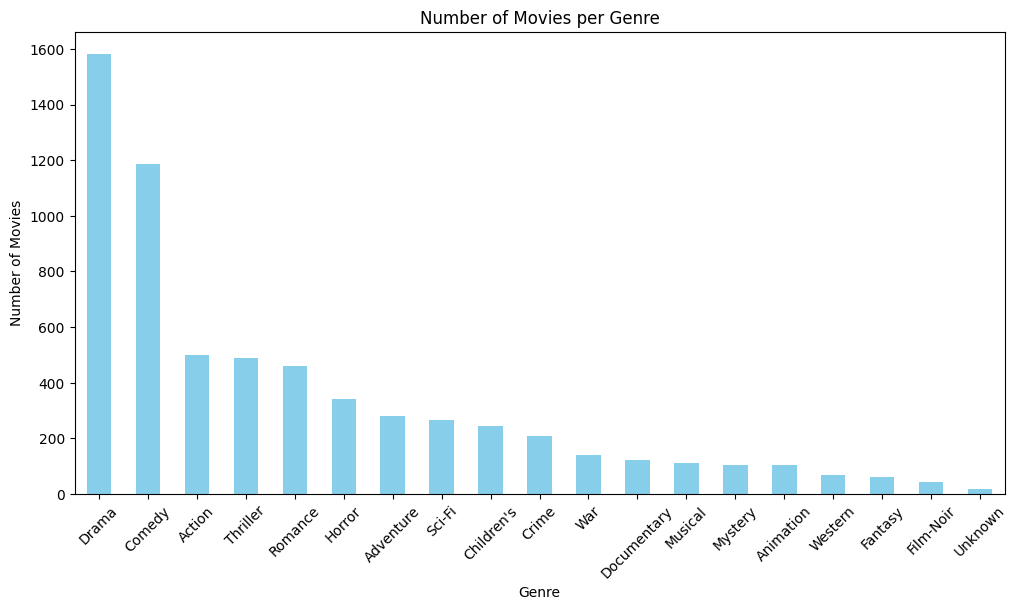

In [ ]:
# Sum of movies in each genre
genre_counts = movies_df.iloc[:, 3:].sum().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

- Highest number of movies nearly 1600 belong to Drama followed by Comedy and then Action

**Year Wise Trend**

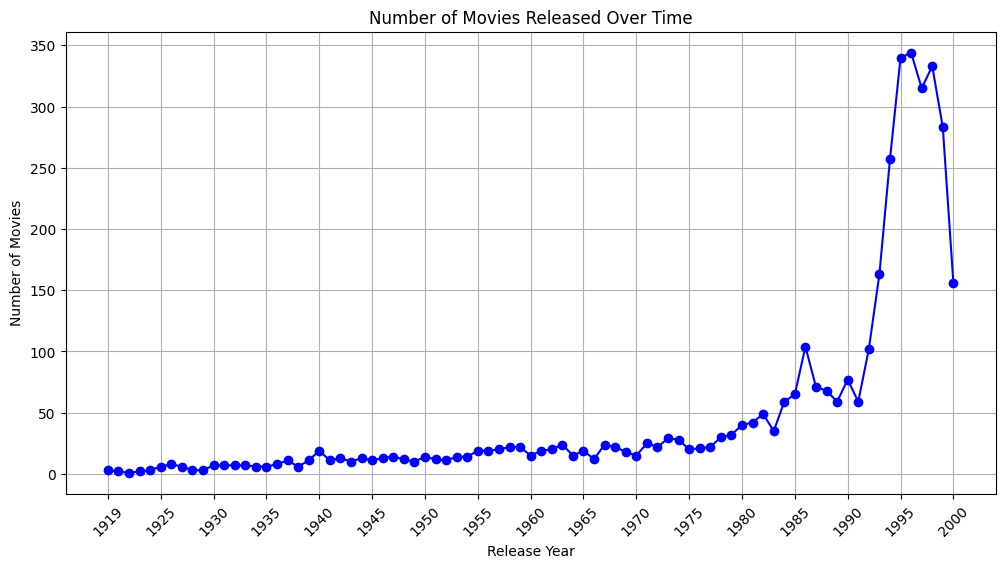

In [ ]:
# Count movies by ReleaseYear
year_counts = movies_df['ReleaseYear'].value_counts().sort_index()

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', color='b')
plt.title('Number of Movies Released Over Time')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.grid(True)

# Adjust x-axis ticks (display every 5th year)
plt.xticks(ticks=year_counts.index[::5], rotation=45)

plt.show()

- Release Year has got the range from 1919 to 2000
- Maximum movies got released in 1996 and 1995

**Genre Popularity by Year**

<Figure size 1500x800 with 0 Axes>

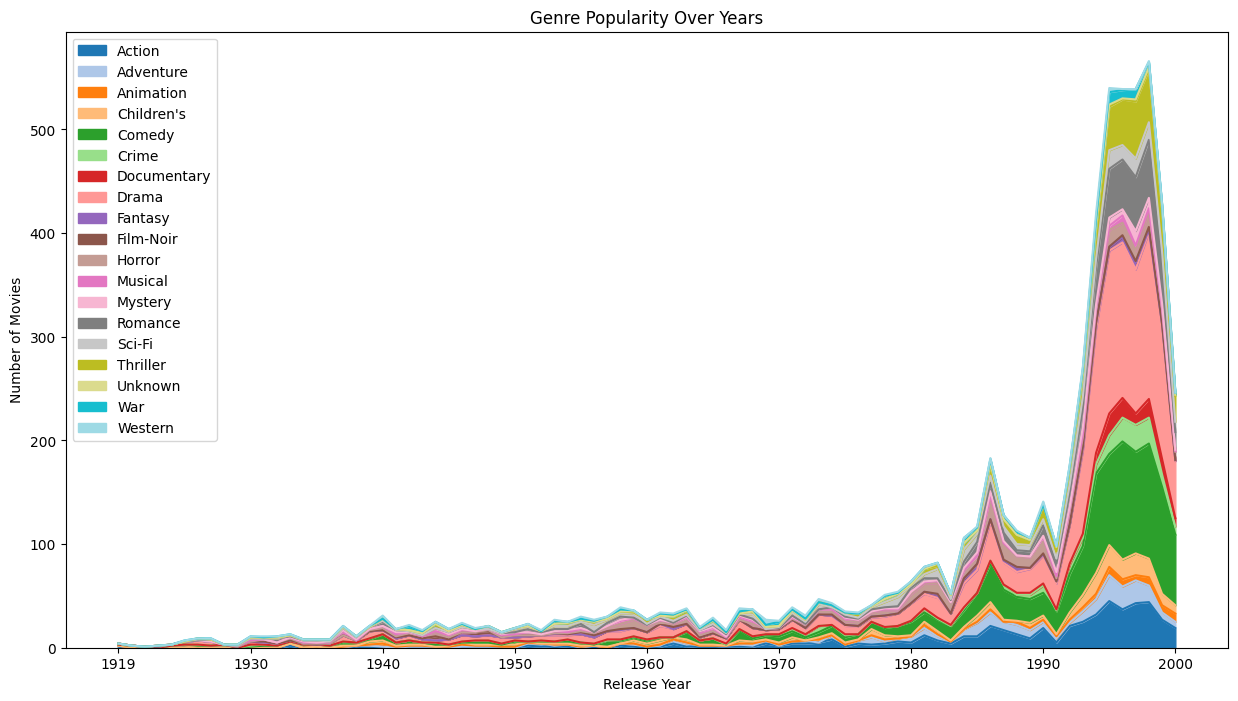

In [ ]:
# Aggregate by ReleaseYear
genre_by_year = movies_df.groupby('ReleaseYear').sum()

# Stacked area plot
plt.figure(figsize=(15, 8))
genre_by_year.iloc[:, 2:].plot(kind='area', stacked=True, figsize=(15, 8), colormap='tab20')
plt.title('Genre Popularity Over Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.legend(loc='upper left')
plt.show()

- Number of Movies in Action, Comedy, Drama Genre have increased over years.
- Percentage of Western and Animation movies have relatively remained same over the years
- Crime and Thriller based movies have shown sharp increase around 1995

##Ratings

**Distribution of Ratings**

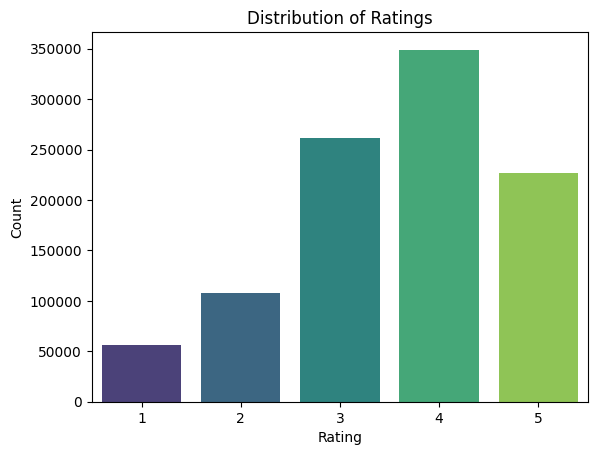

In [ ]:
sns.countplot(data=ratings_df, x='Rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Maximum Ratings given by users is 4 followed 3 and 5

**Ratings Over Time**

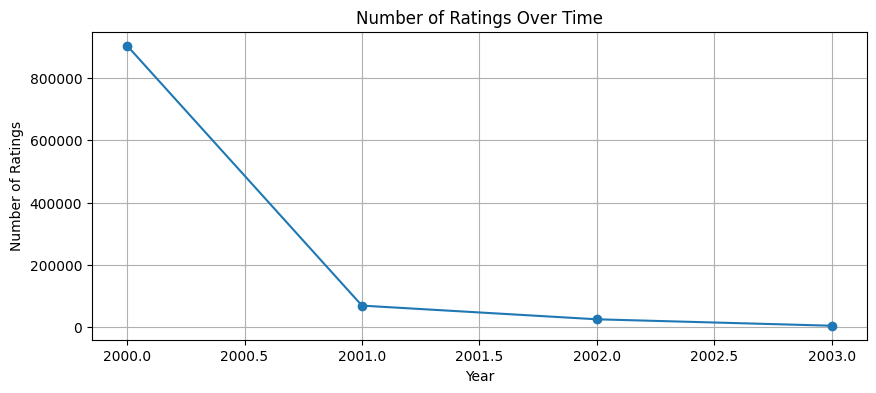

In [ ]:
yearly_ratings = ratings_df.groupby('Year')['Rating'].count()
plt.figure(figsize=(10, 4))
plt.plot(yearly_ratings.index, yearly_ratings.values, marker='o')
plt.title('Number of Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

Maximum number of Ratings were given in the year 2000 which sharply decreased in 2001 and further reducing till 2003

**Most Rated Movies**

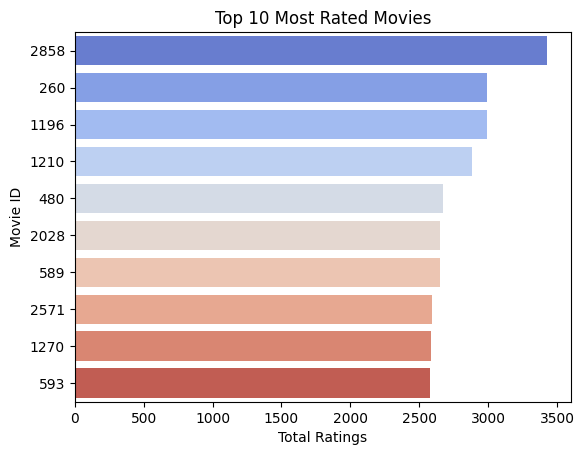

In [ ]:
top_movies = movie_stats.nlargest(10, 'TotalRatingsPerMovie')
sns.barplot(data=top_movies, x='TotalRatingsPerMovie', y='MovieID', palette='coolwarm')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Total Ratings')
plt.ylabel('Movie ID')
plt.show()

MovieID 2858 is the most rated followed by 260 and 1196

**Ratings by Hour and Day**

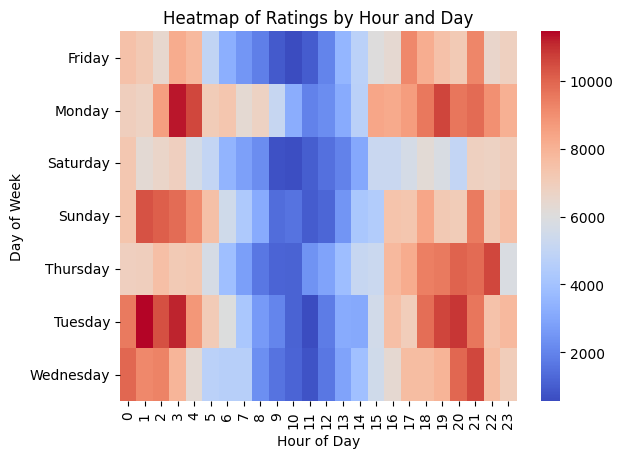

In [ ]:
heatmap_data = ratings_df.groupby(['DayOfWeek', 'Hour'])['Rating'].count().unstack()
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False)
plt.title('Heatmap of Ratings by Hour and Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

- Most of the ratings are given during evening or late night hours.
- Less ratings are given during 6 hrs to 17 hrs of the day

##Users

**Distribution of Gender**

In [ ]:
gender_counts = users_df['Gender'].value_counts()

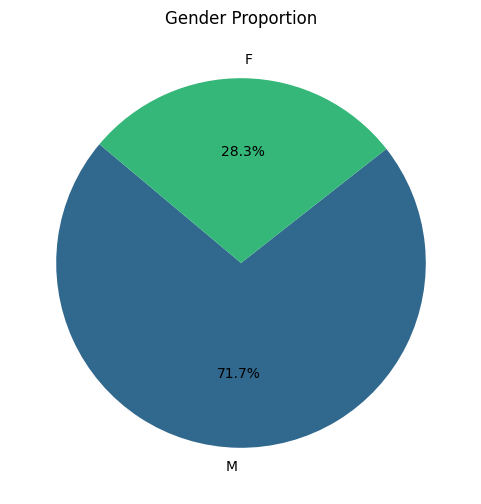

In [ ]:
# Pie chart for Gender distribution
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(gender_counts)))
plt.title('Gender Proportion')
plt.show()

Males are dominating Users distribution with 72% and Females at 28%

**Distribution of Age**

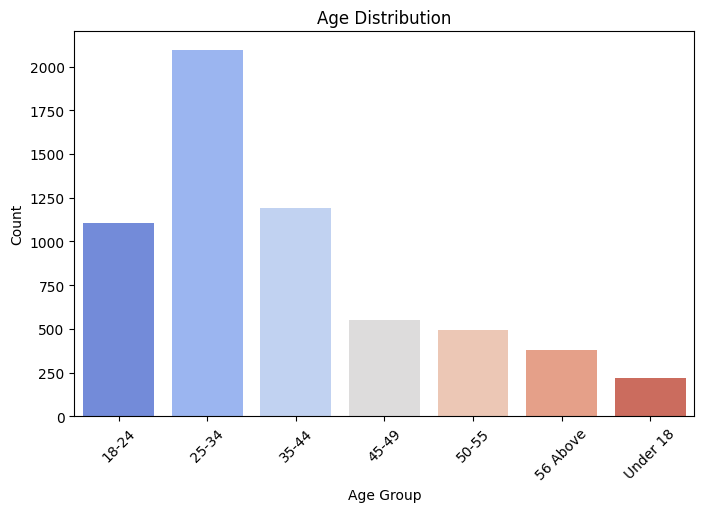

In [ ]:
age_counts = users_df['Age'].value_counts().sort_index()

# Bar plot for Age distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=age_counts.index, y=age_counts.values, palette='coolwarm')
plt.title('Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

More than 2000 users belong to age group 25-34 followed by 35-44 and 18-24 with approx. 1100-1200 users

**Distribution of Occupation**

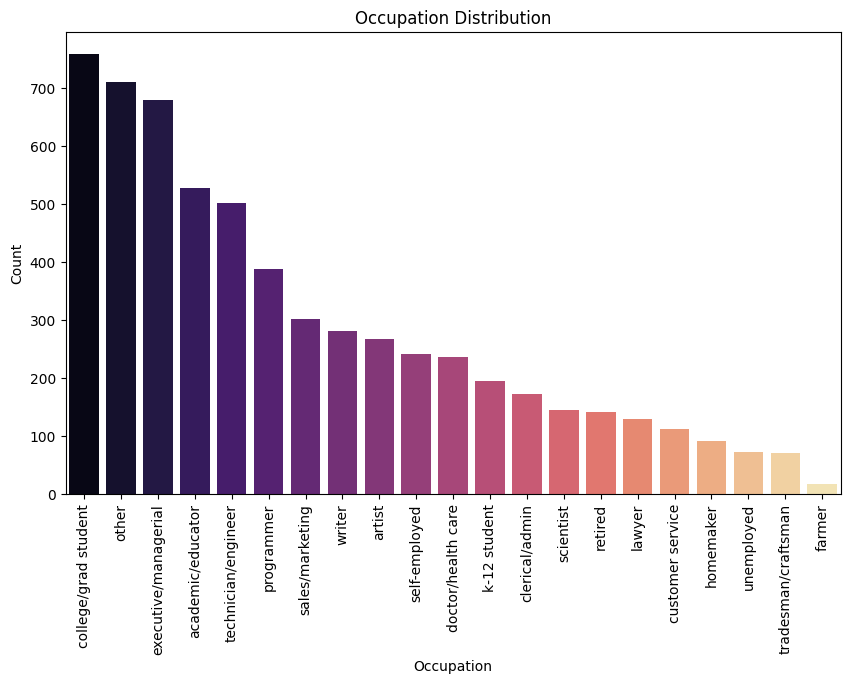

In [ ]:
occupation_counts = users_df['Occupation'].value_counts()

# Bar plot for Occupation distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=occupation_counts.index, y=occupation_counts.values, palette='magma')
plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Maximum users belong to 'college/grad student' category followed by other and executive/managerial

**Distribution of Zip-codes**

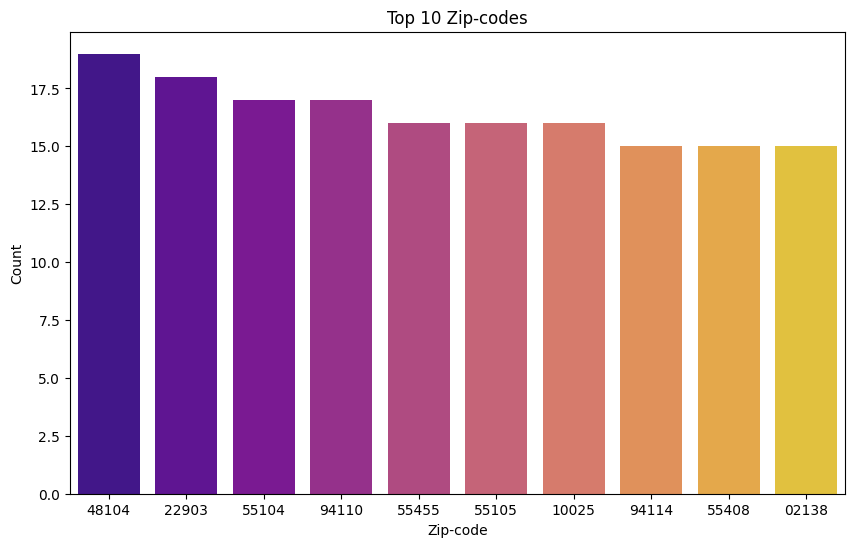

In [ ]:
top_zipcodes = users_df['Zip-code'].value_counts().head(10)

# Bar plot for Top 10 Zip-codes
plt.figure(figsize=(10, 6))
sns.barplot(x=top_zipcodes.index, y=top_zipcodes.values, palette='plasma')
plt.title('Top 10 Zip-codes')
plt.xlabel('Zip-code')
plt.ylabel('Count')
plt.show()

- Among the top 10 zip-codes in terms of users count, four zip codes start with 55.
- Most of the users belong to zip-code 48104 followed by 22903 and 55104

**Aggregate to understand user trends**

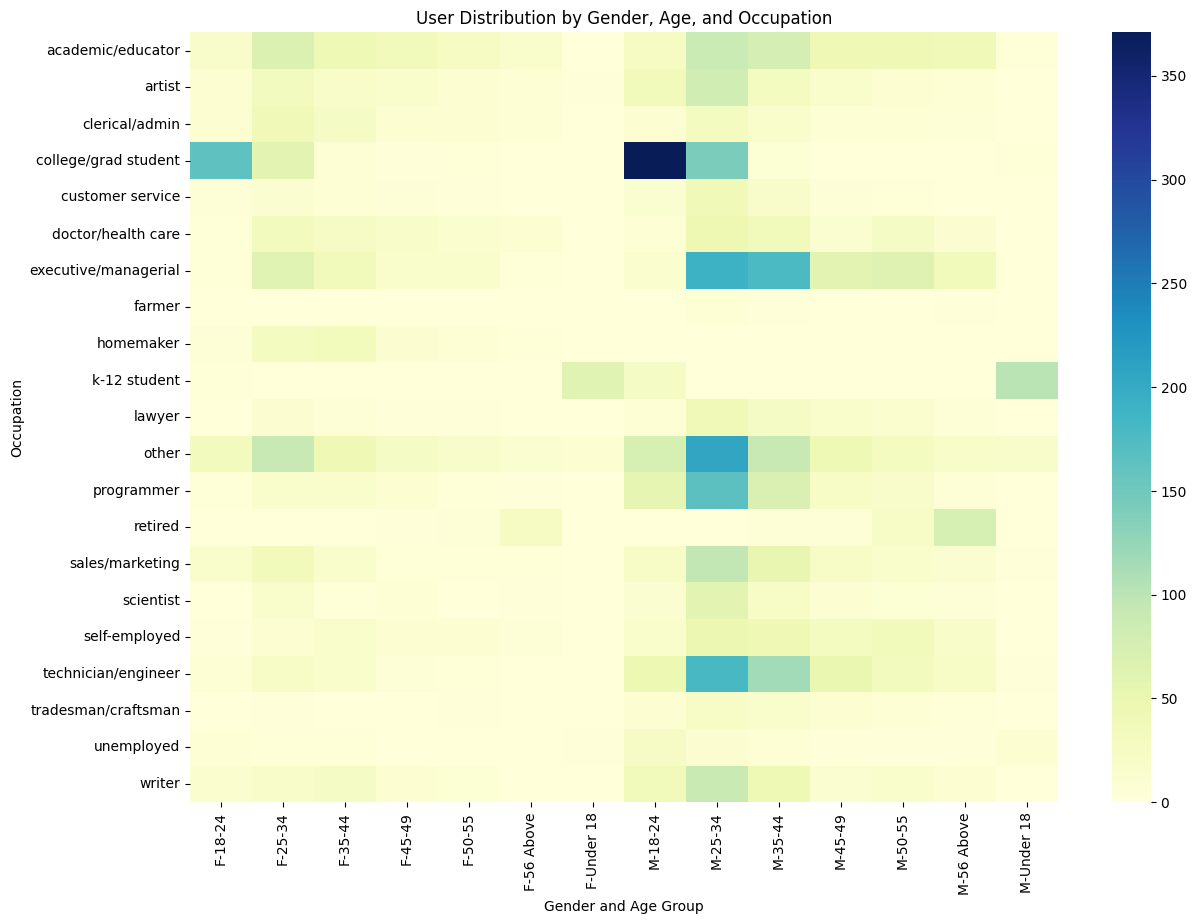

In [ ]:
gender_age_occupation = users_df.groupby(['Gender', 'Age', 'Occupation']).size().reset_index(name='Count')

# Heatmap of Gender-Age-Occupation combinations
pivot_data = gender_age_occupation.pivot_table(index='Occupation', columns=['Gender', 'Age'], values='Count', fill_value=0)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_data, annot=False, cmap='YlGnBu', cbar=True)
plt.title('User Distribution by Gender, Age, and Occupation')
plt.xlabel('Gender and Age Group')
plt.ylabel('Occupation')
plt.show()

- Maximum users (almost 400 numbers) are Male, 18-24 age group, college/grad students.
- Followed by Male, 25-34 age group who are in occupations like technician/engineer, other, executive/managerial

#Collaborative Filtering with Pearson Correlation

In [ ]:
# Create the pivot table
pivot_table = ratings_df.pivot_table(index='MovieID', columns='UserID', values='Rating', fill_value=0)

# Join MovieName from movies_df
movie_id_to_name = movies_df[['MovieID', 'MovieName']].set_index('MovieID')
pivot_table = pivot_table.join(movie_id_to_name, how='left').set_index('MovieName')

In [ ]:
pivot_table.head()

,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
MovieName,,,,,,,,,,,,,,,,,,,,,
Toy Story,5.0,5.0,0.0,5.0,4.0,0.0,0.0,5.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0
GoldenEye,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
City Hall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Curdled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ed's Next Move,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_item_matrix=pivot_table.copy()

##Handling Sparsity

In [ ]:
# Step 1: Calculate Sparsity
total_possible_entries = user_item_matrix.shape[0] * user_item_matrix.shape[1]  # Total cells in the matrix
actual_non_zero_entries = user_item_matrix[user_item_matrix > 0].count().sum()  # Non-zero entries

sparsity = 1 - (actual_non_zero_entries / total_possible_entries)  # Sparsity calculation

print(f"Sparsity of the user-item matrix: {sparsity * 100:.2f}%")

Sparsity of the user-item matrix: 95.53%


In [ ]:
# Step 1: Filter movies with sufficient valid ratings
min_ratings_per_movie = 100
valid_movie_ratings = (user_item_matrix > 0).sum(axis=1)  # Count of valid ratings (> 0.0) per movie
user_item_matrix = user_item_matrix.loc[valid_movie_ratings >= min_ratings_per_movie]

# Step 2: Filter users with sufficient valid ratings
min_ratings_per_user = 50
valid_user_ratings = (user_item_matrix > 0).sum(axis=0)  # Count of valid ratings (> 0.0) per user
user_item_matrix = user_item_matrix.loc[:, valid_user_ratings >= min_ratings_per_user]

# Step 3: Calculate sparsity
total_possible_entries = user_item_matrix.shape[0] * user_item_matrix.shape[1]
actual_ratings = (user_item_matrix > 0).sum().sum()  # Count of valid ratings (> 0.0)

sparsity = 1 - (actual_ratings / total_possible_entries)

print(f"Updated Sparsity of the user-item matrix: {sparsity * 100:.2f}%")


Updated Sparsity of the user-item matrix: 89.58%


Data is inherently sparse. Setting threshold is one way based on domain knowledge to handly sparsity.

##Correlation Matrix

In [ ]:
# Normalize Ratings
normalized_matrix = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0)

In [ ]:
# Compute Pearson Correlation
correlation_matrix = normalized_matrix.T.corr(method='pearson')

In [ ]:
correlation_matrix

MovieName,Toy Story,GoldenEye,City Hall,Extreme Measures,"Glimmer Man, The",D3: The Mighty Ducks,"Apple Dumpling Gang, The",Escape to Witch Mountain,Bottle Rocket,"Love Bug, The",...,"39 Steps, The",Night of the Living Dead,"African Queen, The",Cat on a Hot Tin Roof,"Blue Angel, The (Blaue Engel, Der)",Fly Away Home,Michael Collins,Big Night,Last Man Standing,2 Days in the Valley
MovieName,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.165284,0.061140,0.092748,0.035637,0.114571,0.113645,0.124955,0.104770,0.143409,...,0.046880,0.017191,0.033680,0.049363,-0.010052,0.130694,0.044748,0.079886,0.081032,0.078447
GoldenEye,0.165284,1.000000,0.107435,0.140387,0.183567,0.110831,0.123814,0.128309,0.040400,0.155390,...,0.046331,0.048557,0.059140,0.025218,-0.010846,0.089176,0.090125,-0.002126,0.256379,0.139841
City Hall,0.061140,0.107435,1.000000,0.241540,0.113235,0.040424,0.069412,0.091786,0.089778,0.051115,...,0.102659,0.041709,0.067426,0.075428,0.000118,0.066711,0.177396,0.168937,0.167586,0.164672
Extreme Measures,0.092748,0.140387,0.241540,1.000000,0.176822,0.023349,0.086851,0.122693,0.041222,0.076465,...,0.073231,0.036821,0.011631,0.038229,0.004053,0.062230,0.105421,0.061941,0.146446,0.251038
"Glimmer Man, The",0.035637,0.183567,0.113235,0.176822,1.000000,0.037029,0.061708,0.016468,-0.006415,0.053506,...,0.031915,0.052369,0.024838,0.040740,-0.001575,0.020713,0.067072,0.020123,0.275761,0.113603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fly Away Home,0.130694,0.089176,0.066711,0.062230,0.020713,0.143787,0.098732,0.133227,0.020982,0.135960,...,0.042945,0.008658,0.086850,0.055132,0.030155,1.000000,0.068071,0.092540,0.034182,0.063137
Michael Collins,0.044748,0.090125,0.177396,0.105421,0.067072,0.030555,0.084098,0.087807,0.065910,0.063874,...,0.042328,0.046016,0.100486,0.088959,0.035391,0.068071,1.000000,0.174306,0.103801,0.119388
Big Night,0.079886,-0.002126,0.168937,0.061941,0.020123,-0.000573,0.015237,0.059526,0.165543,0.049569,...,0.146257,0.051849,0.112753,0.189533,0.088036,0.092540,0.174306,1.000000,0.028401,0.139350


##Recommendation

In [ ]:
def recommend_movies(movie_name, correlation_matrix, top_n=5):
    """
    Recommends movies based on the highest Pearson Correlation.

    Parameters:
        movie_name (str): Name of the movie to base recommendations on.
        correlation_matrix (pd.DataFrame): Correlation matrix with MovieName as rows and columns.
        top_n (int): Number of recommendations to return.

    Returns:
        pd.Series: Top N recommended movies with their correlation scores.
    """
    if movie_name not in correlation_matrix.index:
        raise ValueError(f"Movie '{movie_name}' not found in the correlation matrix.")

    # Retrieve the correlations for the given movie
    movie_correlations = correlation_matrix[movie_name]

    # Exclude the input movie itself
    movie_correlations = movie_correlations.drop(labels=movie_name)

    # Sort movies by correlation in descending order
    top_recommendations = movie_correlations.sort_values(ascending=False).head(top_n)

    return top_recommendations


# Example usage
# Assuming `correlation_matrix` is the correlation matrix DataFrame
movie_name_input = "Toy Story"  # Replace with any movie name
try:
    recommendations = recommend_movies(movie_name_input, correlation_matrix)
    print(f"Top recommendations for '{movie_name_input}':")
    print(recommendations)
except ValueError as e:
    print(e)


Top recommendations for 'Toy Story':
MovieName
Toy Story 2             0.463062
Aladdin                 0.434722
Bug's Life, A           0.392486
Lion King, The          0.373634
Beauty and the Beast    0.361543
Name: Toy Story, dtype: float64


#Cosine Similarity Based Rec Sys

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [ ]:
user_item_dense = user_item_matrix.values

In [ ]:
user_item_dense

array([[5., 5., 0., ..., 4., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 3., 0., 0.]])

##User Similarity Matrix

In [ ]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_dense.T)

# Convert to a DataFrame for readability
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Print User Similarity Matrix
print("User Similarity Matrix:")
print(user_similarity_df)

User Similarity Matrix:
             1        10       100      1000      1001      1002      1004  \
1     1.000000  0.261787  0.125020  0.209565  0.149456  0.112020  0.182331   
10    0.261787  1.000000  0.262388  0.283442  0.179109  0.114892  0.439445   
100   0.125020  0.262388  1.000000  0.297539  0.085989  0.111208  0.238244   
1000  0.209565  0.283442  0.297539  1.000000  0.107729  0.048004  0.357046   
1001  0.149456  0.179109  0.085989  0.107729  1.000000  0.188454  0.170644   
...        ...       ...       ...       ...       ...       ...       ...   
990   0.080778  0.157479  0.099138  0.171664  0.167598  0.047831  0.304003   
991   0.039336  0.193977  0.100418  0.078711  0.031300  0.080747  0.098002   
996   0.173124  0.307883  0.347289  0.333629  0.254384  0.228292  0.354596   
998   0.129806  0.145297  0.122422  0.106174  0.312482  0.227321  0.081717   
999   0.124840  0.253943  0.310443  0.248769  0.201181  0.181750  0.339361   

          1005      1008      1009  ...

##Item Similarity Matrix

In [ ]:
# Compute cosine similarity between items (movies)
item_similarity = cosine_similarity(user_item_dense)

# Convert to a DataFrame for readability
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Print Item Similarity Matrix
print("Item Similarity Matrix:")
print(item_similarity_df)

Item Similarity Matrix:
MovieName             Toy Story  GoldenEye  City Hall  Extreme Measures  \
MovieName                                                                 
Toy Story              1.000000   0.400530   0.153949          0.174990   
GoldenEye              0.400530   1.000000   0.167786          0.195373   
City Hall              0.153949   0.167786   1.000000          0.261759   
Extreme Measures       0.174990   0.195373   0.261759          1.000000   
Glimmer Man, The       0.118816   0.224977   0.133774          0.195438   
...                         ...        ...        ...               ...   
Fly Away Home          0.239534   0.174118   0.100275          0.095163   
Michael Collins        0.160285   0.164553   0.203646          0.133327   
Big Night              0.265007   0.137329   0.210349          0.109074   
Last Man Standing      0.209375   0.324535   0.198632          0.177548   
2 Days in the Valley   0.218774   0.229813   0.198044          0.279819   



##KNN Algorithm

In [ ]:
# Fit a Nearest Neighbors model using the item similarity matrix
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item_dense)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
def recommend_movies(movie_name, user_item_matrix, item_similarity_df, model_knn, n_neighbors=5):
    """
    Recommend movies using an Item-Based Collaborative Filtering approach.

    Parameters:
        movie_name (str): The name of the movie to base recommendations on.
        user_item_matrix (pd.DataFrame): User-item matrix of ratings.
        item_similarity_df (pd.DataFrame): Precomputed item similarity matrix.
        model_knn (NearestNeighbors): Fitted nearest neighbors model.
        n_neighbors (int): Number of similar movies to recommend.

    Returns:
        pd.Series: Recommended movies with similarity scores.
    """
    if movie_name not in user_item_matrix.index:
        return f"Movie '{movie_name}' not found in the dataset."

    # Get the index of the input movie
    movie_index = user_item_matrix.index.get_loc(movie_name)

    # Find the nearest neighbors
    distances, indices = model_knn.kneighbors(user_item_dense[movie_index].reshape(1, -1), n_neighbors=n_neighbors+1)

    # Get recommended movie indices and distances
    recommended_indices = indices.flatten()[1:]  # Exclude the input movie
    recommended_distances = distances.flatten()[1:]

    # Map indices back to movie names
    recommended_movies = user_item_matrix.index[recommended_indices]

    # Combine results into a DataFrame
    recommendations = pd.DataFrame({
        'Movie': recommended_movies,
        'Distance': recommended_distances
    }).sort_values(by='Distance', ascending=True)

    return recommendations


In [ ]:
# Input movie for recommendation
input_movie = "Toy Story"

# Get recommendations
recommendations = recommend_movies(input_movie, user_item_matrix, item_similarity_df, model_knn, n_neighbors=5)

print(f"Top 5 recommendations for '{input_movie}':")
print(recommendations)

Top 5 recommendations for 'Toy Story':
                Movie  Distance
0         Toy Story 2  0.342778
1       Groundhog Day  0.364586
2             Aladdin  0.372198
3       Bug's Life, A  0.378554
4  Back to the Future  0.389510


In [ ]:
# Input movie for recommendation
input_movie = "Liar Liar"

# Get recommendations
recommendations = recommend_movies(input_movie, user_item_matrix, item_similarity_df, model_knn, n_neighbors=5)

print(f"Top 5 recommendations for '{input_movie}':")
print(recommendations)

Top 5 recommendations for 'Liar Liar':
                        Movie  Distance
0              Mrs. Doubtfire  0.428992
1  Ace Ventura: Pet Detective  0.465319
2               Dumb & Dumber  0.476022
3                  Home Alone  0.479516
4               Wayne's World  0.486732


#Matrix Factorization

In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505177 sha256=08eece83f7506a96580a2bc3edce7e7f4e455e5575b0a66883020fdb8f31efe4
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [ ]:
# Preparing the data
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings_df[['UserID', 'MovieID', 'Rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# Train an SVD model
svd_model = SVD(n_factors=4)
svd_model.fit(trainset)

# Predictions
predictions = svd_model.test(testset)

##Evaluation- RMSE / MAPE

In [ ]:
# Evaluation
rmse = accuracy.rmse(predictions)

RMSE: 0.8764


An RMSE of 0.8813 indicates that, on average, model's predicted ratings deviate from the true ratings by approximately 0.88 units.

In [ ]:
# MAPE Function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract true and predicted ratings
true_ratings = [pred.r_ui for pred in predictions]
pred_ratings = [pred.est for pred in predictions]

mape = mean_absolute_percentage_error(true_ratings, pred_ratings)
print(f"MAPE: {mape:.2f}%")

MAPE: 26.78%


A MAPE of 26.82% means that, on average, model's predictions are off by 26.82% of the true ratings.

##Obtain and Visualize Embeddings PCA / TSNE

In [ ]:
from sklearn.decomposition import PCA

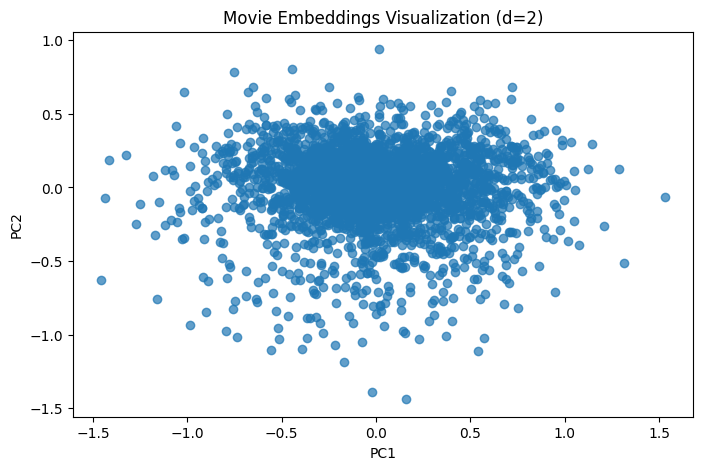

In [ ]:
# Example: Movie Embeddings
movie_embeddings = svd_model.qi  # Movie latent factors (Q matrix)

# PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
movie_embeddings_2d = pca.fit_transform(movie_embeddings)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(movie_embeddings_2d[:, 0], movie_embeddings_2d[:, 1], alpha=0.7)
plt.title('Movie Embeddings Visualization (d=2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
from sklearn.manifold import TSNE

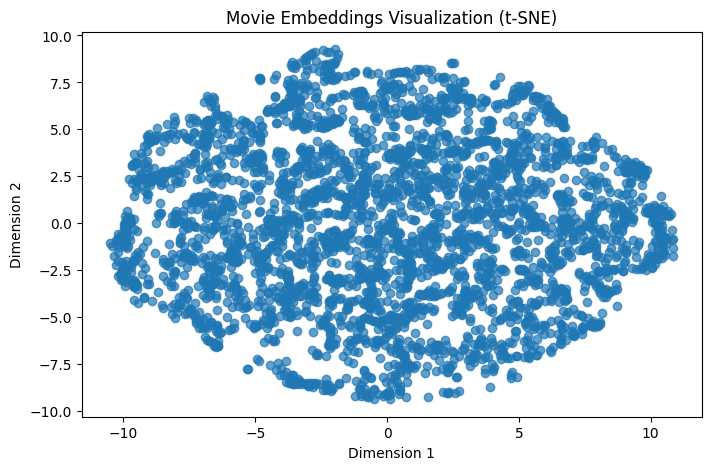

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
movie_embeddings_tsne = tsne.fit_transform(movie_embeddings)

plt.figure(figsize=(8, 5))
plt.scatter(movie_embeddings_tsne[:, 0], movie_embeddings_tsne[:, 1], alpha=0.7)
plt.title('Movie Embeddings Visualization (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Embedding Visualization:
- PCA clusters movies based on genres or similar user ratings.
- t-SNE offers better local clustering but look harder to interpret globally.

##Movie Recommendation

In [ ]:
# Cosine similarity for movie embeddings
similarities = cosine_similarity(movie_embeddings)

# Example: Recommend similar movies for a specific MovieID
movie_index = 2  # Example: First movie
# Exclude the movie itself by masking its similarity score
similarities[movie_index, movie_index] = -np.inf
similar_movies = similarities[movie_index].argsort()[-5:][::-1]  # Top 5
print(f"Movies similar to {movies_df.iloc[movie_index]['MovieName']}:")
for idx in similar_movies:
    print(movies_df.iloc[idx]['MovieName'])

Movies similar to City Hall:
Gothic
House of the Spirits, The
2010
Crossfire
Nô


#Insights

- Highest number of movies nearly 1600 belong to Drama followed by Comedy and then Action
- Release Year has got the range from 1919 to 2000
- Maximum movies got released in 1996 and 1995
- Number of Movies in Action, Comedy, Drama Genre have increased over years.
- Percentage of Western and Animation movies have relatively remained same over the years
- Crime and Thriller based movies have shown sharp increase around 1995
- Maximum Ratings given by users is 4 followed 3 and 5
- Maximum number of Ratings were given in the year 2000 which sharply decreased in 2001 and further reducing till 2003
- MovieID 2858 is the most rated followed by 260 and 1196
- Most of the ratings are given during evening or late night hours.
- Less ratings are given during 0600 hrs to 1700 hrs of the day
- Males are dominating Users distribution with 72% and Females at 28%
- More than 2000 users belong to age group 25-34 followed by 35-44 and 18-24 with approx. 1100-1200 users
- Maximum users belong to 'college/grad student' category followed by 'other' and 'executive/managerial'
- Among the top 10 zip-codes in terms of users count, four zip codes start with 55.
- Most of the users belong to zip-code 48104 followed by 22903 and 55104
- Maximum users (almost 400 numbers) are Male, 18-24 age group, college/grad students.
- Followed by Male, 25-34 age group who are in occupations like technician/engineer, other, executive/managerial
- Sparsity of the user-item matrix: 95.53%
- Movie Recommendations have been made using collaborative filtering with Pearson Correlation
- Movie Recommendations made using Cosine similarity and KNN algorithm
- User Similarity matrix is generated
- Item similarity matrix is generated
- Movie Recommendations also shared on Matrix Factorization using scikit-surprise library and SVD
- RMSE of the svd model is found to be 0.8813 and MAPE is 27.18%
- PCA clusters movies based on genres or similar user ratings.
- t-SNE offers better local clustering but look harder to interpret globally.


#Business Recommendations

1. Enhancing User Engagement and Satisfaction

  - Personalized Recommendations: The recommender system’s ability to tailor suggestions based on user preferences, demographics, and historical ratings is key to improving engagement. By aligning recommendations with user tastes, the platform can foster deeper connections with its content.

  - Diverse Suggestions: Ensure that recommendations balance highly rated popular movies with lesser-known but highly rated niche films to encourage discovery.

  - Timing Insights: Given the insights on rating activity, personalized notifications or reminders during peak engagement hours (evenings and late nights) can improve interaction rates.

2. Increasing User Retention and Platform Usage

  - Dynamic User Profiles: Continuously update user profiles based on their recent interactions to make recommendations more relevant.

  - Rewarding Engagement: Introduce gamification elements, such as badges or rewards for rating movies, which can increase platform stickiness.

  - Community Features: Allow users to create watchlists, share recommendations with friends, or participate in movie-related discussions.

3. Accuracy and Patterns in User Preferences

  - Rating Patterns: Most ratings are between 3 and 4, suggesting moderate satisfaction. Focus on enhancing recommendations for users with mid-range ratings to identify potential favorites.

  - Demographic Trends: Tailor recommendations based on demographics, e.g., males in the 18-24 age group who dominate the user base.

  - Genre Insights: Leverage the increase in Action, Comedy, and Drama movies to highlight trending genres, while also featuring underrepresented genres for variety.

4. Comparison of Model Performance

  - **Pearson Correlation:**

    Strengths: Effective for capturing linear relationships between users’ preferences.

    Limitations: Limited scalability with sparse datasets (95.53% sparsity).

  - **Cosine Similarity:**

    Strengths: Captures angle-based similarity; works well with sparse data.

    Limitations: Does not consider magnitude, which can limit nuanced comparisons.

  - **Matrix Factorization (SVD):**

    Strengths: Captures latent factors that influence user preferences. Offers the best predictive performance with RMSE (0.8813) and MAPE (27.18%).

    Limitations: Requires substantial computational resources and fine-tuning.

5. Strategies for Refinement

  - Incorporate Implicit Feedback: Include data such as time spent browsing movies, clicks, or watch completions to enhance recommendations.

  - Hybrid Models: Combine collaborative filtering with content-based methods to improve accuracy, especially for new users or less-rated movies.

  - Hyperparameter Tuning: Optimize SVD and other algorithms by exploring different configurations (e.g., number of latent factors, regularization).

6. Monitoring and Updating the System

  - Periodic Retraining: Regularly retrain models using updated data to adapt to evolving user preferences.

  - User Feedback Loop: Collect explicit feedback on recommendations to refine the model.

  - Performance Metrics: Track RMSE, MAPE, and user satisfaction metrics to assess system efficacy.

7. Areas for Further Research

  - Temporal Dynamics: Explore how preferences shift over time and integrate time-aware models.

  - Cross-Domain Recommendations: Leverage insights from other content types (e.g., TV shows, books) for richer recommendations.

  - Demographic Diversity: Investigate trends for underrepresented groups to enhance inclusivity.

8. Scalability and Adaptability

  - Scalability: Ensure models can handle growth in users and content by leveraging distributed computing frameworks.

  - Content Adaptability: Extend the system to other media types like music or games, using genre or feature-based embeddings for flexibility.

  - User Segments: Customize strategies for high-value users (e.g., frequent raters) and new users (e.g., cold-start problem).

**Conclusion:**

By combining accurate, personalized recommendations with strategies to enhance engagement and scalability, the movie recommender system can drive user satisfaction and retention. Regular monitoring and incorporating diverse feedback mechanisms will ensure the system evolves in line with user behaviors and preferences.



#Questionnaire

**1. Users of which age group have watched and rated the most number of movies?**

Ans: More than 2000 users belong to age group 25-34 who have watched and rated most number of movies

**2. Users belonging to which profession have watched and rated the most movies?**

Ans: From above EDA and plot the answer is 'College/grad students'

**3. Most of the users in our dataset who’ve rated the movies are Male (T/F)?**

Ans: True, 72% are Males

**4. Most of the movies present in our dataset were released in which decade? 70s b. 90s c. 50s d.80s**

Ans: From the time series plot above, maximum movies got released in the year 1995 and 1996 , so the answer is 90s

**5. The movie with maximum no. of ratings is ___.**

In [ ]:
# Find the row with the maximum TotalRatingsPerMovie
max_ratings_movie = movie_stats.loc[movie_stats['TotalRatingsPerMovie'].idxmax()]

# Extract the MovieID and corresponding stats
print(f"Movie with maximum ratings:")
print(f"MovieID: {max_ratings_movie['MovieID']}")
print(f"Average Rating: {max_ratings_movie['AvgRatingPerMovie']}")
print(f"Total Ratings: {max_ratings_movie['TotalRatingsPerMovie']}")

Movie with maximum ratings:
MovieID: 2858
Average Rating: 4.3173862310385065
Total Ratings: 3428


In [ ]:
# Merge to get MovieName
movie_with_max_ratings = movies_df.merge(
    movie_stats.loc[[movie_stats['TotalRatingsPerMovie'].idxmax()]],
    on='MovieID'
)

print(f"Movie Name: {movie_with_max_ratings['MovieName'].values[0]}")
print(f"Average Rating: {movie_with_max_ratings['AvgRatingPerMovie'].values[0]}")
print(f"Total Ratings: {movie_with_max_ratings['TotalRatingsPerMovie'].values[0]}")

Movie Name: American Beauty
Average Rating: 4.3173862310385065
Total Ratings: 3428


Ans: American Beauty is the movie with maximum rating

**6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.**

In [ ]:
# Input movie for recommendation
input_movie = "Liar Liar"

# Get recommendations
recommendations = recommend_movies(input_movie, user_item_matrix, item_similarity_df, model_knn, n_neighbors=5)

print(f"Top 5 recommendations for '{input_movie}':")
print(recommendations)

Top 5 recommendations for 'Liar Liar':
                        Movie  Distance
0              Mrs. Doubtfire  0.428992
1  Ace Ventura: Pet Detective  0.465319
2               Dumb & Dumber  0.476022
3                  Home Alone  0.479516
4               Wayne's World  0.486732


Ans: Top 3 movies similar to 'Liar Liar' are
- Mrs. Doubtfire
- Ace Ventura: Pet Detective
- Dumb & Dumber

**7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.**

Ans: On the basis of approach, Collaborative Filtering methods can be classified into user-based and item-based.

**8. Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.**

Pearson Correlation ranges between -1 to +1.

- -1 indicates a perfect negative linear relationship.
- +1 indicates a perfect positive linear relationship.
- 0 indicates no linear relationship.

Cosine Similarity belongs to the interval between 0 to 1 (if dealing with non-negative vectors).

- 0 indicates no similarity.
- 1 indicates complete similarity (vectors are identical).

**9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.**

Ans: RMSE is found to be 0.8813 and MAPE is 27.18%

**10. Give the sparse ‘row’ matrix representation for the following dense matrix-**

[[1 0]
[3 7]]

Ans: (row_ptr, col_indices, values)=([0,1,3],[0,0,1],[1,3,7])